In [39]:
# import tensorflow as tf

# from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import skimage.measure

import random
import copy
import math
import cv2
import os

In [40]:
div = 64
step = int(32/4)
red = 1

box = 4
kernel = np.ones((box,box),np.float32)/(box**2)

# Random sample div x div windows in map
n_crops = 300  #500

map_list = ['stanford_bookstore0', 'stanford_bookstore4', 'stanford_coupa0', 'stanford_coupa1', 
            'stanford_coupa2', 'stanford_coupa3', 'stanford_gates2', 'stanford_gates6', 
            'stanford_hyang2', 'stanford_hyang3', 'stanford_hyang4', 'stanford_hyang10', 
            'stanford_little3',  'stanford_nexus0',  'stanford_nexus1', 'stanford_deathCircle0']
# semantic class cash is used also for bike parking spots
# sem_dict = ['cash', 'entrance', 'light', 'sit', 'stairs', 'trash', 'tree','restricted','grass','intersection','shadow']
sem_dict = ['bicycle_road', 'building', 'entrance', 'grass', 'obstacle', 'parking', 'pedestrian_road', 'tree', 'vehicle_road']
chans = len(sem_dict)

lut_in = [0, 10, 30, 50, 70, 110, 150, 255]
lut_out = [0, 120, 200, 225, 240, 248, 250, 255]
lut_in = [0, 10, 70, 150, 255]
lut_out = [0, 130, 210, 245, 255]
# plt.plot(lut_in, lut_out)
lut_8u = np.interp(np.arange(0, 256), lut_in, lut_out).astype(np.uint8)

train_x = np.zeros((1, div, div, chans))
train_y = np.zeros((1, div, div))
train_y1 = np.zeros((1, div, div))
train_y2 = np.zeros((1, div, div))

spec = 'stan'
train_data_dir = 'training_data'

stanford_bookstore0


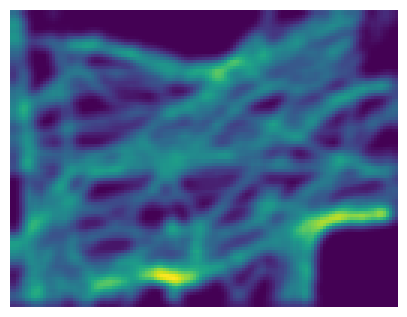

libpng warning: iCCP: known incorrect sRGB profile


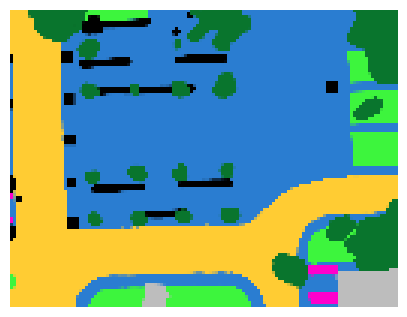

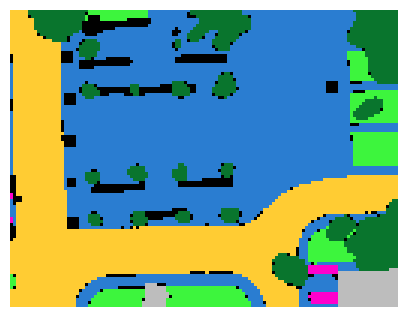

stanford_bookstore4


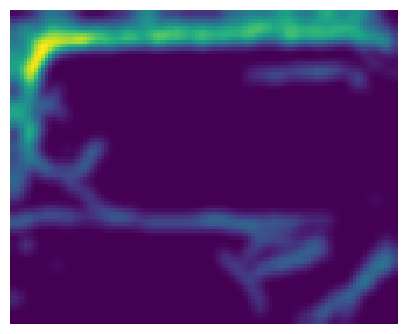

libpng warning: iCCP: known incorrect sRGB profile


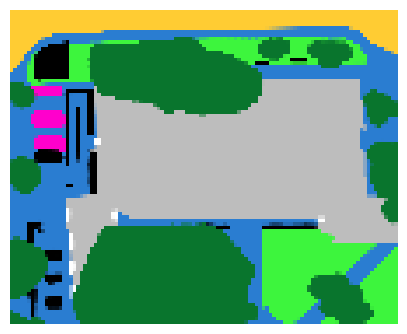

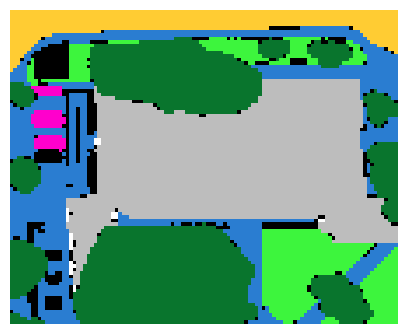

stanford_coupa0


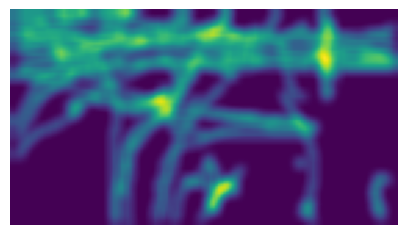

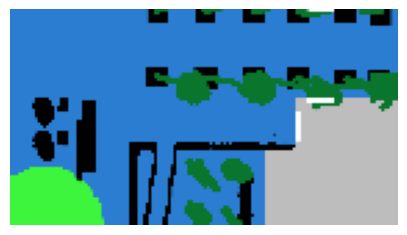

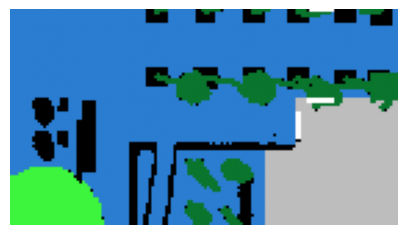

stanford_coupa1


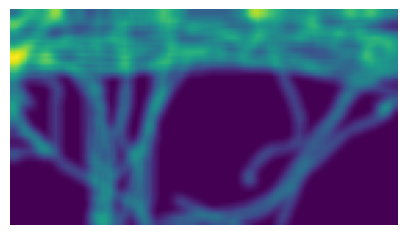

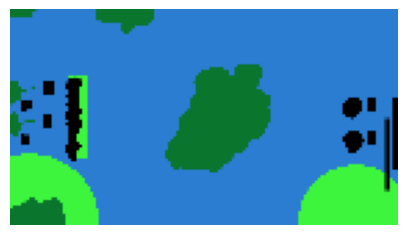

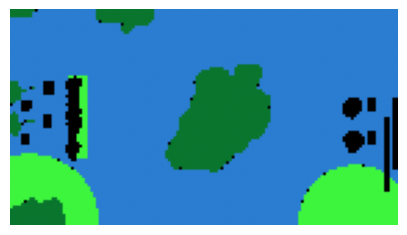

stanford_coupa2


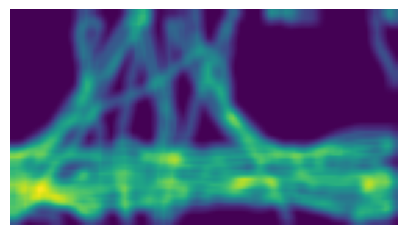

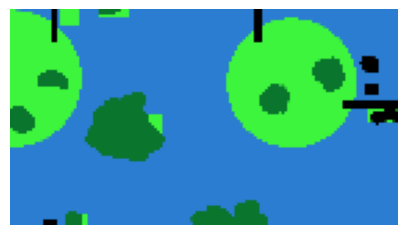

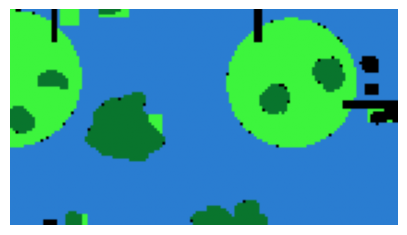

stanford_coupa3


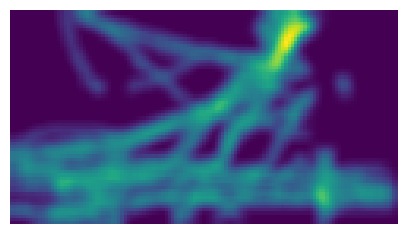

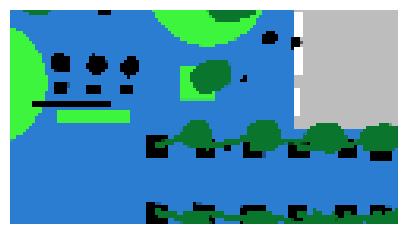

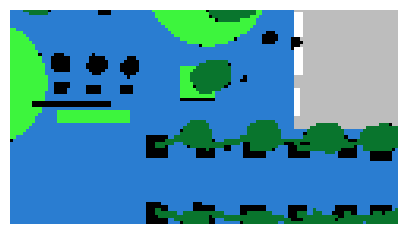

stanford_gates2


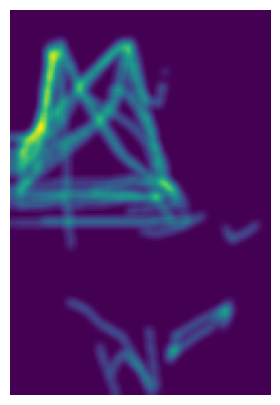

libpng warning: iCCP: known incorrect sRGB profile


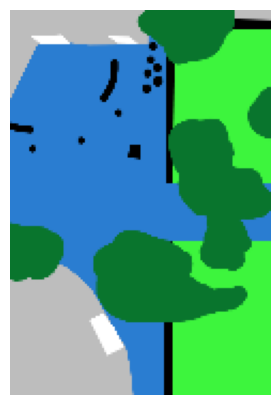

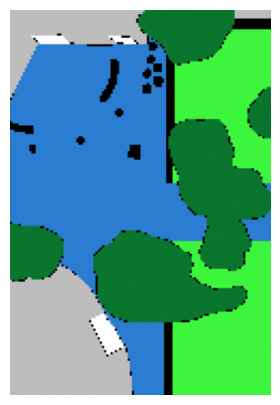

stanford_gates6


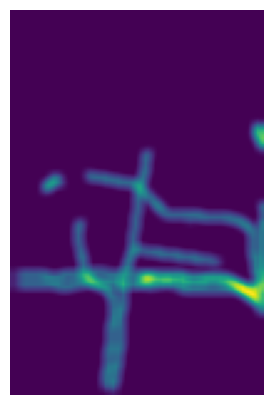

libpng warning: iCCP: known incorrect sRGB profile


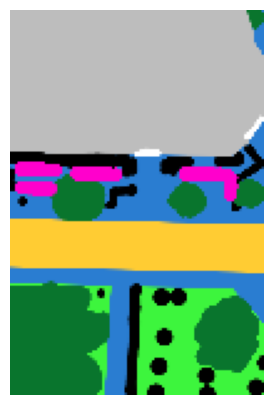

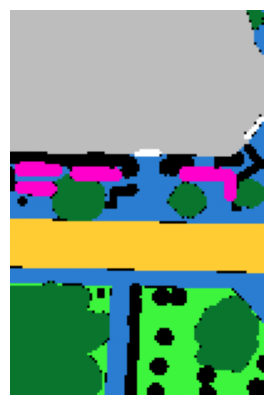

stanford_hyang2


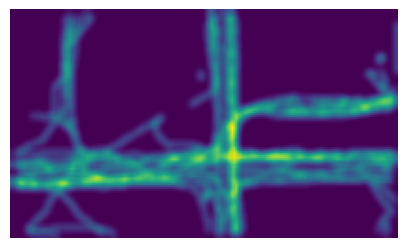

libpng warning: iCCP: known incorrect sRGB profile


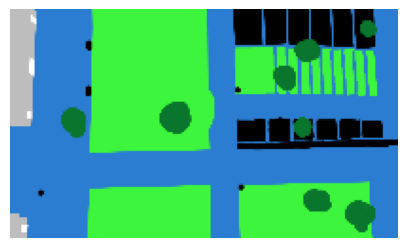

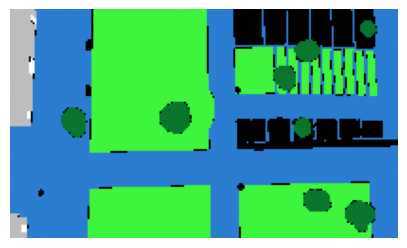

stanford_hyang3


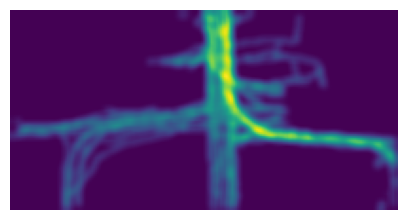

libpng warning: iCCP: known incorrect sRGB profile


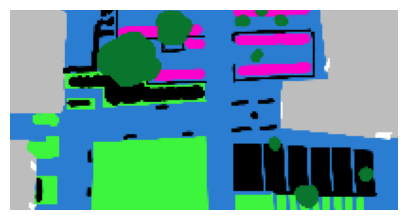

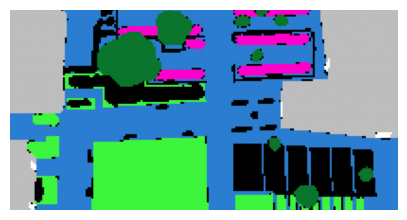

stanford_hyang4


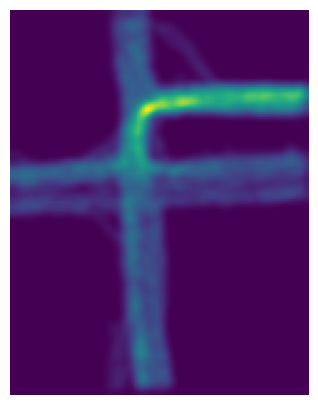

libpng warning: iCCP: known incorrect sRGB profile


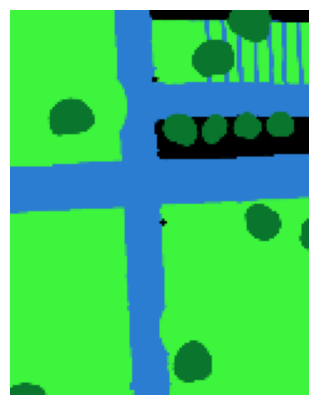

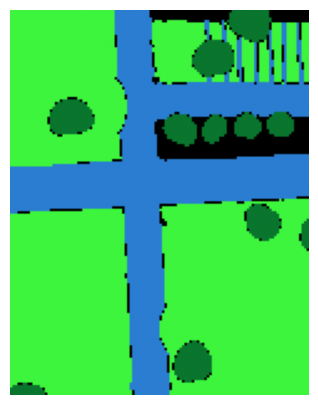

stanford_hyang10


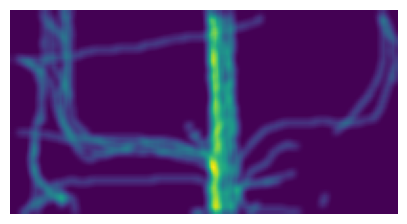

libpng warning: iCCP: known incorrect sRGB profile


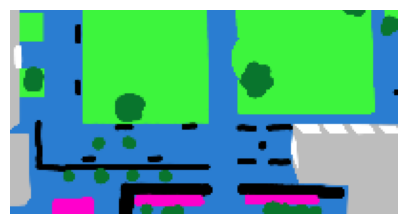

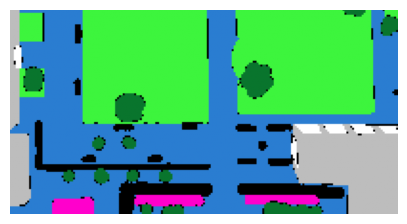

stanford_little3


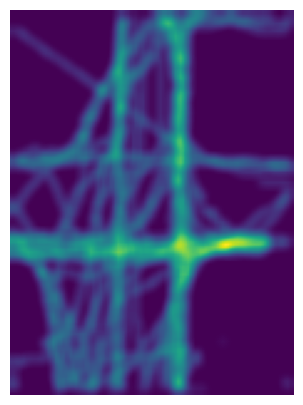

libpng warning: iCCP: known incorrect sRGB profile


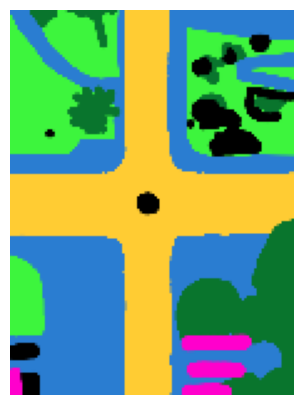

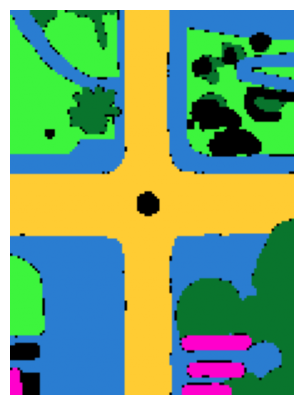

stanford_nexus0


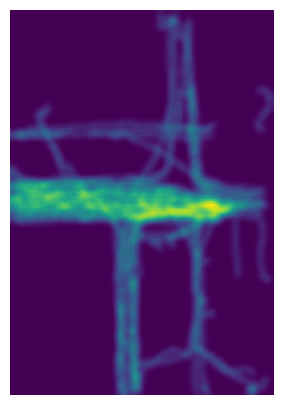

libpng warning: iCCP: known incorrect sRGB profile


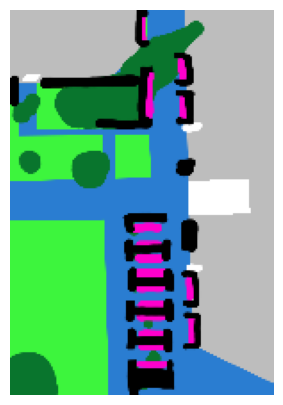

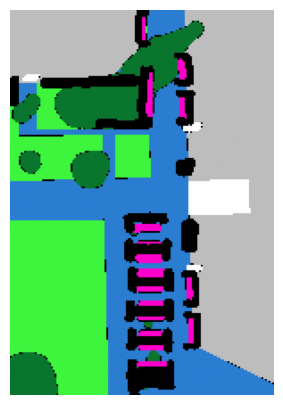

stanford_nexus1


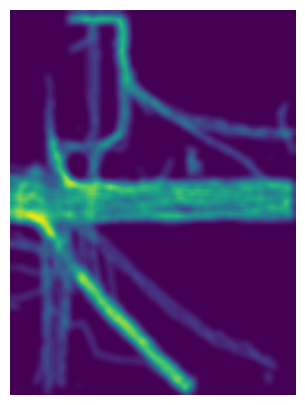

libpng warning: iCCP: known incorrect sRGB profile


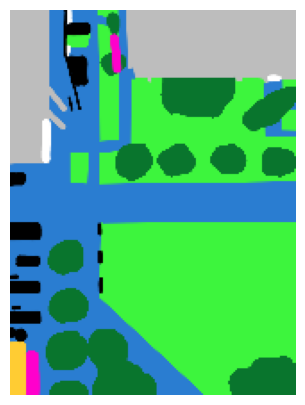

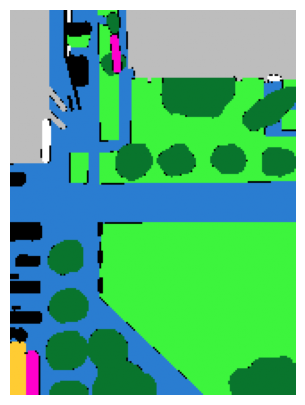

stanford_deathCircle0


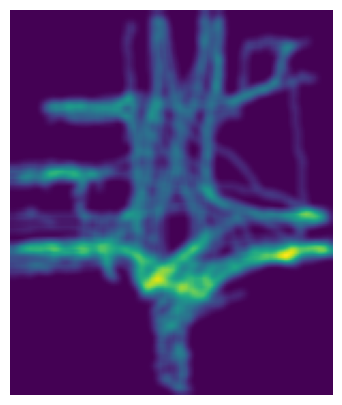

libpng warning: iCCP: known incorrect sRGB profile


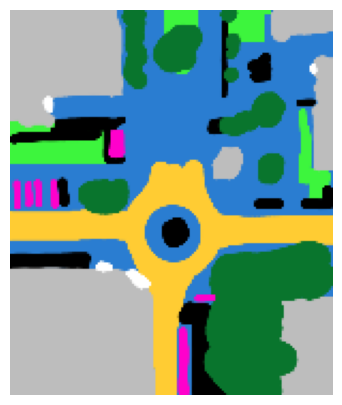

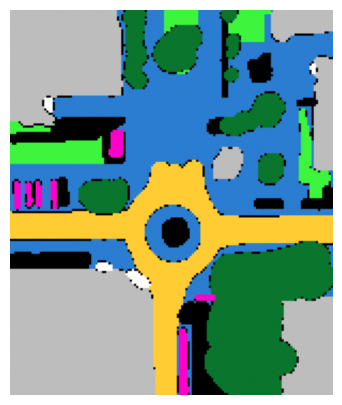

Done


In [41]:
for map_count, map_name in enumerate(map_list):
  print(map_name)

  # -----------------------------------------------------------------------------------
  lines = 0
  with open('maps/semantics/'+map_name+'/humandensity-'+map_name+'-new.csv') as f:
    lines = f.readlines()

  hd = len(lines)
  wd = len(lines[0].split(','))

  # Converts data to a list of integers
  data = []
  for line in lines:
    data.extend([float(c) for c in line.split(',')])

  data = np.reshape(data,[hd,wd])
  data = skimage.measure.block_reduce(data, (red,red), np.max)

  # print(data.shape)
  hd, wd = data.shape
  
  data_show = data
  data_show = cv2.filter2D(data_show,-1,kernel)
  data_show = cv2.filter2D(data_show,-1,kernel)
  data = data_show/np.sum(data_show)
  data_show = data_show/np.max(data_show)
  fig = plt.figure(figsize=(5,5))
  plt.imshow(data_show)
  plt.axis('off')
  plt.show()

  # -----------------------------------------------------------------------------------

  png_path = 'maps/semantics/'+map_name+'/'+map_name+'_colors.png'
  labelmap_path = 'maps/semantics/labelmap.txt'

  # Read the labelmap file
  with open(labelmap_path, 'r') as f:
      labelmap = f.readlines()
  labelmap.pop(0)
  labelmap.pop(0)

  # Load the PNG image
  image = cv2.imread(png_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  image = cv2.resize(image, (wd,hd), interpolation = cv2.INTER_LINEAR)
  map = np.zeros((hd,wd,chans))

  # fig = plt.figure(figsize=(5,5))
  # plt.imshow(image)
  # plt.axis('off')
  # plt.show()

  colors = []
  # Iterate over each label in the labelmap
  for i, label in enumerate(labelmap):
      label = label.strip().split(':')
      label_name = label[0]
      label_color = np.array(label[1].split(','), dtype=int)
      colors.append(label_color)
      # Create a mask for the pixels with the label color
      map[:,:,i] = 255-cv2.inRange(image, label_color-10, label_color+10)

  map = map/255

  # print(map.shape)
  h, w, _ = map.shape

  sem_map = np.zeros((h,w,3))
  for i in range(len(sem_dict)):
    sem = np.full((h,w,3),colors[i])
    sem_map = np.stack((1-map[:,:,i],1-map[:,:,i],1-map[:,:,i]), axis=2)*sem+sem_map
  fig = plt.figure(figsize=(5,5))
  plt.imshow(sem_map/255)
  plt.axis('off')
  plt.show()

  # -----------------------------------------------------------------------------------

if True:

#   # # -----------------------------------------------------------------------------------
#   # lines = 0
#   # with open('maps/semantics/'+map_name+'/humandensity-'+map_name+'-vel.csv') as f:
#   #   lines = f.readlines()

#   # hd = len(lines)
#   # wd = len(lines[0].split(','))

#   # # Converts data to a list of integers
#   # data1 = []
#   # for line in lines:
#   #   data1.extend([float(c) for c in line.split(',')])

#   # data1 = np.reshape(data1,[hd,wd])
#   # sigma = 10.0
#   # DA SISTEMARE
#   # data1 = skimage.filters.gaussian(data1, sigma=(sigma, sigma), channel_axis=-1)
#   # data1 = skimage.measure.block_reduce(data1, (red,red), np.max)
#   # data1 = np.subtract(data1, np.full((h, w), np.min(data1)))/(np.max(data1)-np.min(data1))

#   # # print(data1.shape)
#   # hd, wd = data1.shape

#   # # fig = plt.figure(figsize=(5,5))
#   # # plt.imshow(np.multiply(np.stack((map[:,:,0],map[:,:,0],map[:,:,0]),axis=2), np.stack((np.full(data1.shape,1),1-data1,1-data1),axis=2)), vmin=0, vmax=1)
#   # # plt.show()

#   # # -----------------------------------------------------------------------------------
#   # lines = 0
#   # with open('maps/semantics/'+map_name+'/humandensity-'+map_name+'-stop.csv') as f:
#   #   lines = f.readlines()

#   # hd = len(lines)
#   # wd = len(lines[0].split(','))

#   # # Converts data to a list of integers
#   # data2 = []
#   # for line in lines:
#   #   data2.extend([float(c) for c in line.split(',')])

#   # data2 = np.reshape(data2,[hd,wd])
#   # sigma = 10.0
#   # DA SISTEMARE
#   # data2 = skimage.filters.gaussian(data2, sigma=(sigma, sigma), channel_axis=-1)
#   # data2 = skimage.measure.block_reduce(data2, (red,red), np.max)
#   # data2 = np.subtract(data2, np.full((h, w), np.min(data2)))/(np.max(data2)-np.min(data2))

#   # # print(data2.shape)
#   # hd, wd = data2.shape

#   # # fig = plt.figure(figsize=(5,5))
#   # # plt.imshow(np.multiply(np.stack((map[:,:,0],map[:,:,0],map[:,:,0]),axis=2), np.stack((np.full(data2.shape,1),1-data2,1-data2),axis=2)), vmin=0, vmax=1)
#   # # plt.show()

#   # -----------------------------------------------------------------------------------
#   # fig = plt.figure(figsize=(5,5))
#   data_pred = np.zeros((int(math.ceil(h)),int(math.ceil(w))))
#   # data_pred1 = np.zeros((int(math.ceil(h)),int(math.ceil(w))))
#   # data_pred2 = np.zeros((int(math.ceil(h)),int(math.ceil(w))))

#   num = 0
#   numv = 0
#   start = train_x.shape[0] - 1

#   inserted = 0
#   crops = np.zeros((n_crops,2),dtype=int)
#   selections = np.zeros((h,w))
#   for i in range(n_crops):
#     background = np.zeros((h,w))
#     flag = True
#     while flag:
#       aux_x = int(random.random()*(w-div+1))
#       aux_y = int(random.random()*(h-div+1))
#       flag = False

#       submap = map[aux_y:aux_y+div, aux_x:aux_x+div,:]
#       subdata = data[aux_y:aux_y+div, aux_x:aux_x+div]
#       # subdata1 = data1[crops[i,1]:crops[i,1]+div, crops[i,0]:crops[i,0]+div]
#       # subdata2 = data2[crops[i,1]:crops[i,1]+div, crops[i,0]:crops[i,0]+div]
#       # subdata = np.divide(subdata,np.sum(subdata))

#       if not (np.mean(submap) > 0.2 and np.mean(submap) < 1 and np.mean(subdata) > 0 and submap.shape == (div, div, chans)):
#         print('DISCARDED: not enough information')
#         flag = True
#         # test11 = 1-cv2.rectangle(background,(aux_x,aux_y),(aux_x+div-1,aux_y+div-1),(1,0,0),-1)/1.5
#         # test11 = np.multiply(np.stack((test11,test11,test11),axis=2),np.stack((np.full(data.shape,1),1-data,1-data),axis=2))
#         # test11 = np.multiply(test11,np.stack((map[:,:,0],map[:,:,0],map[:,:,0]),axis=2))
        
#         # for i in range(len(sem_dict)):
#         #     alp = 0.5
#         #     test11 = np.multiply(test11,np.stack((map[:,:,i+1],map[:,:,i+1],map[:,:,i+1]),axis=2)*alp+(1-alp))
#         # plt.figure(figsize=(5,5))
#         # plt.imshow(test11)

#         # print(f'\nsubmap mean: {np.mean(submap)}')
#         # print(f'subdata mean: {np.mean(subdata)}')
#         # print(f'submap shape: {submap.shape}')
#         # import sys
#         # sys.exit(0)
#       # print(f'INSERTED: {inserted}  ->  x: {aux_x} and y: {aux_y}')
#       # for z in range(inserted):
#       #   if abs(aux_x-crops[z,0])<int(div/10) and abs(aux_y-crops[z,1])<int(div/10):
#       #     # print('too close')
#       #     flag = True
        
#     crops[i,0] = aux_x
#     crops[i,1] = aux_y
#     selections = selections+cv2.rectangle(background,(crops[i,0],crops[i,1]),(crops[i,0]+div-1,crops[i,1]+div-1),(1,0,0),-1)
#     inserted = inserted + 1

#     num = num + 1
#     train_x = np.append(train_x, np.expand_dims(submap, axis=0), axis=0)
#     train_y = np.append(train_y, np.expand_dims(subdata, axis=0), axis=0)
#     # train_y1 = np.append(train_y1, np.expand_dims(subdata1, axis=0), axis=0)
#     # train_y2 = np.append(train_y2, np.expand_dims(subdata2, axis=0), axis=0)

#   selections = 1/selections

#   for i in range(n_crops):
#     submap = map[crops[i,1]:crops[i,1]+div, crops[i,0]:crops[i,0]+div, :]
#     subdata = data[crops[i,1]:crops[i,1]+div, crops[i,0]:crops[i,0]+div]
#     if np.max(subdata) > 1 or np.min(subdata) < 0:
#       print(f'subdata max: {np.max(subdata)}')
#       print(f'subdata min: {np.min(subdata)}')
#     data_pred[crops[i,1]:crops[i,1]+div, crops[i,0]:crops[i,0]+div] += subdata*selections[crops[i,1]:crops[i,1]+div, crops[i,0]:crops[i,0]+div]
#     # data_pred1[crops[i,1]:crops[i,1]+div, crops[i,0]:crops[i,0]+div] += subdata1*selections[crops[i,1]:crops[i,1]+div, crops[i,0]:crops[i,0]+div]
#     # data_pred2[crops[i,1]:crops[i,1]+div, crops[i,0]:crops[i,0]+div] += subdata2*selections[crops[i,1]:crops[i,1]+div, crops[i,0]:crops[i,0]+div]
  
#   data_show = data_pred/np.max(data_pred)

#   # lim_val = 0.2
#   # data_show = np.clip(data,0,np.max(data)*lim_val)/(np.max(data)*lim_val)
#   # data_show = cv2.LUT((data_show*255).astype(np.uint8), lut_8u).astype(np.float32)/255
#   fig = plt.figure(figsize=(5,5))
#   plt.imshow(data_show)
#   plt.axis('off')
#   plt.show()
  
#   # plt.imshow(np.multiply(np.stack((map[:,:,0],map[:,:,0],map[:,:,0]),axis=2), np.stack((np.full(data_pred1.shape,1),1-data_pred1,1-data_pred1),axis=2)))
#   # plt.show()
#   # plt.imshow(np.multiply(np.stack((map[:,:,0],map[:,:,0],map[:,:,0]),axis=2), np.stack((np.full(data_pred2.shape,1),1-data_pred2,1-data_pred2),axis=2)))
#   # plt.show()

#   # -----------------------------------------------------------------------------------


#   for i in np.arange(num)+start:
#     if i % 100 == 0:
#       print(i)
#     for j in np.arange(3):
#       train_x = np.append(train_x, np.expand_dims(np.rot90(train_x[i,:,:], k=j+1, axes=(0, 1)),axis=0), axis=0)
#       train_y = np.append(train_y, np.expand_dims(np.rot90(train_y[i,:,:], k=j+1, axes=(0, 1)),axis=0), axis=0)
#       # train_y1 = np.append(train_y1, np.expand_dims(np.rot90(train_y1[i,:,:], k=j+1, axes=(0, 1)),axis=0), axis=0)
#       # train_y2 = np.append(train_y2, np.expand_dims(np.rot90(train_y2[i,:,:], k=j+1, axes=(0, 1)),axis=0), axis=0)
    
#     train_x = np.append(train_x, np.expand_dims(np.flip(train_x[i,:,:], axis=0), axis=0),axis=0)
#     train_x = np.append(train_x, np.expand_dims(np.flip(train_x[i,:,:], axis=1), axis=0),axis=0)
#     train_y = np.append(train_y, np.expand_dims(np.flip(train_y[i,:,:], axis=0), axis=0),axis=0)
#     train_y = np.append(train_y, np.expand_dims(np.flip(train_y[i,:,:], axis=1), axis=0),axis=0)
#     # train_y1 = np.append(train_y1, np.expand_dims(np.flip(train_y1[i,:,:], axis=0), axis=0),axis=0)
#     # train_y1 = np.append(train_y1, np.expand_dims(np.flip(train_y1[i,:,:], axis=1), axis=0),axis=0)
#     # train_y2 = np.append(train_y2, np.expand_dims(np.flip(train_y2[i,:,:], axis=0), axis=0),axis=0)
#     # train_y2 = np.append(train_y2, np.expand_dims(np.flip(train_y2[i,:,:], axis=1), axis=0),axis=0)

#   ############################################################################################################
#   ############################################################################################################
#   ############################################################################################################

#   train_x = np.delete(train_x, 0, 0)
#   train_y = np.delete(train_y, 0, 0)
#   train_y1 = np.delete(train_y1, 0, 0)
#   train_y2 = np.delete(train_y2, 0, 0)

#   print(train_x.shape)
  
#   output_dir = train_data_dir+'/'+str(div)+'crop_size/'+str(len(sem_dict))+'labels/'+str(red)+'red/'+map_name
#   # Create the output directory if it doesn't exist
#   os.makedirs(output_dir, exist_ok=True)
#   np.savetxt(output_dir+'/train_X.csv', np.insert(train_x.flatten(),0,train_x.shape), delimiter=',', fmt='%f')
#   np.savetxt(output_dir+'/train_Y.csv', np.insert(train_y.flatten(),0,train_y.shape), delimiter=',', fmt='%f')

#   train_x = np.zeros((1, div, div, chans))
#   train_y = np.zeros((1, div, div))
#   train_y1 = np.zeros((1, div, div))
#   train_y2 = np.zeros((1, div, div))

#   ############################################################################################################
#   ############################################################################################################
#   ############################################################################################################

# # # Show the random crop selection of the map
# # fig = plt.figure(figsize=(w/12,h/12))
# # plt.imshow(selections, vmin=0, vmax=1, cmap='magma')
# # plt.colorbar()
# # plt.show()

# train_x = np.delete(train_x, 0, 0)
# train_y = np.delete(train_y, 0, 0)
# train_y1 = np.delete(train_y1, 0, 0)
# train_y2 = np.delete(train_y2, 0, 0)

# print(train_x.shape)
  print('Done')


In [42]:
# num_validation = 0.5
 
# original_data_x = train_x
# original_data_y = train_y
# original_data_y1 = train_y1
# original_data_y2 = train_y2

In [43]:
# train_x = original_data_x
# train_y = original_data_y
# # train_y1 = original_data_y1
# # train_y2 = original_data_y2

# p = np.random.permutation(len(train_x))
# train_x = train_x[p]
# train_y = train_y[p]
# # train_y1 = train_y1[p]
# # train_y2 = train_y2[p]

# num = train_x.shape[0]
# num_test = int(num*num_validation)

# test_x = train_x[:num_test,:,:]
# test_y = train_y[:num_test,:,:]
# # test_y1 = train_y1[:num_test,:,:]
# # test_y2 = train_y2[:num_test,:,:]

# train_x = train_x[num_test:,:,:]
# train_y = train_y[num_test:,:,:]
# # train_y1 = train_y1[num_test:,:,:]
# # train_y2 = train_y2[num_test:,:,:]

# print(train_x.shape)
# print(test_x.shape)

In [44]:
# np.savetxt(train_data_dir+'/train_X.csv', np.insert(train_x.flatten(),0,train_x.shape), delimiter=',', fmt='%f')
# np.savetxt(train_data_dir+'/train_Y.csv', np.insert(train_y.flatten(),0,train_y.shape), delimiter=',', fmt='%f')
# # np.savetxt(train_data_dir+'/train_Y1.csv', np.insert(train_y1.flatten(),0,train_y1.shape), delimiter=',', fmt='%f')
# # np.savetxt(train_data_dir+'/train_Y2.csv', np.insert(train_y2.flatten(),0,train_y2.shape), delimiter=',', fmt='%f')

# np.savetxt(train_data_dir+'/test_X.csv', np.insert(test_x.flatten(),0,test_x.shape), delimiter=',', fmt='%f')
# np.savetxt(train_data_dir+'/test_Y.csv', np.insert(test_y.flatten(),0,test_y.shape), delimiter=',', fmt='%f')
# # np.savetxt(train_data_dir+'/test_Y1.csv', np.insert(test_y1.flatten(),0,test_y1.shape), delimiter=',', fmt='%f')
# # np.savetxt(train_data_dir+'/test_Y2.csv', np.insert(test_y2.flatten(),0,test_y2.shape), delimiter=',', fmt='%f')

In [45]:
# i = int(random.random()*test_x.shape[0])
# # i = 6359
# print(i)
# submap = test_x[i,:,:]
# subdata = test_y[i,:,:]

# print(sem_dict)
# plt.figure(figsize=(10,5))
# for i in range(len(sem_dict)):
#     ax = plt.subplot(1, len(sem_dict), i+1)
#     alp = 0.5
#     ax.imshow(np.multiply(np.stack((submap[:,:,i+1],submap[:,:,i+1],submap[:,:,i+1]),axis=2)*alp+(1-alp), np.stack((np.full(subdata.shape,1),1-subdata,1-subdata),axis=2)))
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
# plt.show()
# fig = plt.figure(figsize=(2,2))
# contrasted_subdata = cv2.LUT((subdata/np.max(subdata)*255).astype(np.uint8), lut_8u).astype(float)/255
# plt.imshow(np.multiply(np.stack((submap[:,:,0],submap[:,:,0],submap[:,:,0]),axis=2), np.stack((np.full(subdata.shape,1),1-subdata,1-subdata),axis=2)))
# plt.show()